In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install demoji==1.1.0

In [4]:
!pip install tensorflow

In [5]:
!pip install rich --upgrade

     -------------------------------------- 243.4/243.4 kB 1.4 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 14.0.0
    Uninstalling rich-14.0.0:
      Successfully uninstalled rich-14.0.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.38.0 requires rich<14,>=10.14.0, but you have rich 14.1.0 which is incompatible.
streamlit 1.38.0 requires tenacity<9,>=8.1.0, but you have tenacity 9.0.0 which is incompatible.


In [89]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import demoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,SpatialDropout1D
from tensorflow.keras.layers import Embedding
import warnings
warnings.filterwarnings('ignore')


In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Krishna
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Krishna
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Krishna
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Collection 

##  Loading dataset in a dataframe

In [10]:
df=pd.read_csv("D://Unified mentor internship projects//climate_nasa.csv")
df.head()

,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart..."


In [5]:
df.columns

Index(['date', 'likesCount', 'profileName', 'commentsCount', 'text'], dtype='object')

In [7]:
df.shape

(522, 5)

# Data Wrangling

In [11]:
df.isnull().sum()

date               0
likesCount         0
profileName        0
commentsCount    278
text              18
dtype: int64

In [12]:
df['commentsCount'].replace(np.nan,0.0,inplace=True)
df['text'].replace(np.nan,'Unknown',inplace=True)

In [13]:
df.isnull().sum()

date             0
likesCount       0
profileName      0
commentsCount    0
text             0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           522 non-null    object 
 1   likesCount     522 non-null    int64  
 2   profileName    522 non-null    object 
 3   commentsCount  522 non-null    float64
 4   text           522 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 20.5+ KB


In [14]:
df['date']=pd.to_datetime(df['date'],errors='coerce')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   date           522 non-null    datetime64[ns, UTC]
 1   likesCount     522 non-null    int64              
 2   profileName    522 non-null    object             
 3   commentsCount  522 non-null    float64            
 4   text           522 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(2)
memory usage: 20.5+ KB


In [6]:
df.head()

,date,likesCount,profileName,commentsCount,text
0,2022-09-07 17:12:32+00:00,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,0.0,Neat comparison I have not heard it before.\n ...
1,2022-09-08 14:51:13+00:00,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,0.0,An excellent way to visualise the invisible! T...
2,2022-09-07 17:19:41+00:00,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08 00:51:30+00:00,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,0.0,excellent post! I defo feel the difference - o...
4,2022-09-07 19:06:20+00:00,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart..."


In [14]:
df['text'].head(20)

0     Neat comparison I have not heard it before.\n ...
1     An excellent way to visualise the invisible! T...
2     Does the CO2/ghg in the troposphere affect the...
3     excellent post! I defo feel the difference - o...
4     Yes, and carbon dioxide does not harm the Eart...
5     Excellent example...very relatable to the Gen ...
6     I am so proud of whoever created this content....
7     Has the Earth ever had a concentration of over...
8     Yes, and not even half a cup later that poor s...
9     Historical co2 data would make it an interesti...
10    why the northern hemisphere warm more than the...
11                    So what are we gonna do about it?
12    Yes. I fall asleep on decaf and stay awake wit...
13    Plus you can literally measure the heat retent...
14    The two most abundant gases (nitrogen and oxyg...
15       That's an excellent way to illustrate 400 ppm.
16    I find it interesting when people claim that C...
17                     Love this post! Great ped

In [15]:
for i in range(len(df['text'])): 
    df['text'][i]=demoji.replace(df['text'][i]," ")
    print(df['text'][i])   

C:\Users\Krishna Kumar\AppData\Local\Temp\ipykernel_8644\944960499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=demoji.replace(df['text'][i]," ")


Neat comparison I have not heard it before.
 I would say that CO2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere.
An excellent way to visualise the invisible! Thanks
Does the CO2/ghg in the troposphere affect the stratosphere? Being warmer the troposphere must be expanding?
excellent post! I defo feel the difference - one i can drink and the other makes me feel sick.
Yes, and carbon dioxide does not harm the Earth like you people are making it out to be. Fake climate change rhetoric, as usual.
Excellent example...very relatable to the Gen Pop. Complex topics...explained in understandable ways.   
I am so proud of whoever created this content. Please feel very very good about yourself today
Has the Earth ever had a concentration of over 1000 ppm?
Yes, and not even half a cup later that poor soul is gonna know it too.
Historical co2 data would make it an interesting post
why the northern hemisphere warm more than the southern he

In [12]:
df['text'].head(20)

0     Neat comparison I have not heard it before.\n ...
1     An excellent way to visualise the invisible! T...
2     Does the CO2/ghg in the troposphere affect the...
3     excellent post! I defo feel the difference - o...
4     Yes, and carbon dioxide does not harm the Eart...
5     Excellent example...very relatable to the Gen ...
6     I am so proud of whoever created this content....
7     Has the Earth ever had a concentration of over...
8     Yes, and not even half a cup later that poor s...
9     Historical co2 data would make it an interesti...
10    why the northern hemisphere warm more than the...
11                    So what are we gonna do about it?
12    Yes. I fall asleep on decaf and stay awake wit...
13    Plus you can literally measure the heat retent...
14    The two most abundant gases (nitrogen and oxyg...
15       That's an excellent way to illustrate 400 ppm.
16    I find it interesting when people claim that C...
17                     Love this post! Great ped

In [16]:
for i in range(len(df['text'])):
    print(df['text'][i])

Neat comparison I have not heard it before.
 I would say that CO2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere.
An excellent way to visualise the invisible! Thanks
Does the CO2/ghg in the troposphere affect the stratosphere? Being warmer the troposphere must be expanding?
excellent post! I defo feel the difference - one i can drink and the other makes me feel sick.
Yes, and carbon dioxide does not harm the Earth like you people are making it out to be. Fake climate change rhetoric, as usual.
Excellent example...very relatable to the Gen Pop. Complex topics...explained in understandable ways.   
I am so proud of whoever created this content. Please feel very very good about yourself today
Has the Earth ever had a concentration of over 1000 ppm?
Yes, and not even half a cup later that poor soul is gonna know it too.
Historical co2 data would make it an interesting post
why the northern hemisphere warm more than the southern he

In [17]:
for i in range(len(df['text'])):
    df['text'][i]=df['text'][i].replace('*********'," ")
    df['text'][i]=df['text'][i].replace('!'," ")
    df['text'][i]=df['text'][i].replace('/'," ")
    df['text'][i]=df['text'][i].replace('-'," ")
    df['text'][i]=df['text'][i].replace('...'," ")
    df['text'][i]=df['text'][i].replace('\''," ")
    df['text'][i]=df['text'][i].replace('?'," ")
    df['text'][i]=df['text'][i].replace('('," ")
    df['text'][i]=df['text'][i].replace(')'," ")
    df['text'][i]=df['text'][i].replace('…'," ")
    df['text'][i]=df['text'][i].replace('°C'," ")
    df['text'][i]=df['text'][i].replace('°F'," ")
    df['text'][i]=df['text'][i].replace(','," ")
    df['text'][i]=df['text'][i].replace('……'," ")
    df['text'][i]=df['text'][i].replace(','," ")
    df['text'][i]=df['text'][i].replace('....'," ")
    df['text'][i]=df['text'][i].replace('!!!'," ")
    df['text'][i]=df['text'][i].replace('!!!!!!'," ")
    df['text'][i]=df['text'][i].replace('%'," ")
    df['text'][i]=df['text'][i].replace('#'," ")
    df['text'][i]=df['text'][i].replace('!!!!'," ")
    df['text'][i]=df['text'][i].replace('['," ")
    df['text'][i]=df['text'][i].replace(']'," ")
    df['text'][i]=df['text'][i].replace(':'," ")
    df['text'][i]=df['text'][i].replace('’'," ")
    df['text'][i]=df['text'][i].replace(';'," ")
    df['text'][i]=df['text'][i].replace('='," ")
    df['text'][i]=df['text'][i].replace(' - '," ")
    df['text'][i]=df['text'][i].replace('”'," ")
    df['text'][i]=df['text'][i].replace('..'," ")
    df['text'][i]=df['text'][i].replace('*'," ")
    df['text'][i]=df['text'][i].replace('******'," ")
    df['text'][i]=df['text'][i].replace('°'," ")

C:\Users\Krishna Kumar\AppData\Local\Temp\ipykernel_8644\2377560077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=df['text'][i].replace('*********'," ")
C:\Users\Krishna Kumar\AppData\Local\Temp\ipykernel_8644\2377560077.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=df['text'][i].replace('!'," ")
C:\Users\Krishna Kumar\AppData\Local\Temp\ipykernel_8644\2377560077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [18]:
for i in range(len(df['text'])):
    
    print(df['text'][i])
    

Neat comparison I have not heard it before.
 I would say that CO2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere.
An excellent way to visualise the invisible  Thanks
Does the CO2 ghg in the troposphere affect the stratosphere  Being warmer the troposphere must be expanding 
excellent post  I defo feel the difference   one i can drink and the other makes me feel sick.
Yes  and carbon dioxide does not harm the Earth like you people are making it out to be. Fake climate change rhetoric  as usual.
Excellent example very relatable to the Gen Pop. Complex topics explained in understandable ways.   
I am so proud of whoever created this content. Please feel very very good about yourself today
Has the Earth ever had a concentration of over 1000 ppm 
Yes  and not even half a cup later that poor soul is gonna know it too.
Historical co2 data would make it an interesting post
why the northern hemisphere warm more than the southern hemisp

In [19]:
for i in range(len(df['text'])): 
    df['text'][i]=demoji.replace(df['text'][i],"    ")
    print(df['text'][i]) 

C:\Users\Krishna Kumar\AppData\Local\Temp\ipykernel_8644\374080033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=demoji.replace(df['text'][i],"    ")


Neat comparison I have not heard it before.
 I would say that CO2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere.
An excellent way to visualise the invisible  Thanks
Does the CO2 ghg in the troposphere affect the stratosphere  Being warmer the troposphere must be expanding 
excellent post  I defo feel the difference   one i can drink and the other makes me feel sick.
Yes  and carbon dioxide does not harm the Earth like you people are making it out to be. Fake climate change rhetoric  as usual.
Excellent example very relatable to the Gen Pop. Complex topics explained in understandable ways.   
I am so proud of whoever created this content. Please feel very very good about yourself today
Has the Earth ever had a concentration of over 1000 ppm 
Yes  and not even half a cup later that poor soul is gonna know it too.
Historical co2 data would make it an interesting post
why the northern hemisphere warm more than the southern hemisp

In [20]:
for i in range(len(df['text'])):
    df['text'][i]=df['text'][i].replace(':'," ")
    df['text'][i]=df['text'][i].replace('’'," ")
    df['text'][i]=df['text'][i].replace(';'," ")
    df['text'][i]=df['text'][i].replace('='," ")
    df['text'][i]=df['text'][i].replace(' - '," ")
    df['text'][i]=df['text'][i].replace('”'," ")
    df['text'][i]=df['text'][i].replace('..'," ")
    df['text'][i]=df['text'][i].replace('*'," ")
    df['text'][i]=df['text'][i].replace('******'," ")
    df['text'][i]=df['text'][i].replace('°'," ")
    

C:\Users\Krishna Kumar\AppData\Local\Temp\ipykernel_8644\2543291269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=df['text'][i].replace(':'," ")
C:\Users\Krishna Kumar\AppData\Local\Temp\ipykernel_8644\2543291269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=df['text'][i].replace('’'," ")
C:\Users\Krishna Kumar\AppData\Local\Temp\ipykernel_8644\2543291269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [21]:
for i in range(len(df['text'])):
    
    print(df['text'][i])
    

Neat comparison I have not heard it before.
 I would say that CO2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere.
An excellent way to visualise the invisible  Thanks
Does the CO2 ghg in the troposphere affect the stratosphere  Being warmer the troposphere must be expanding 
excellent post  I defo feel the difference   one i can drink and the other makes me feel sick.
Yes  and carbon dioxide does not harm the Earth like you people are making it out to be. Fake climate change rhetoric  as usual.
Excellent example very relatable to the Gen Pop. Complex topics explained in understandable ways.   
I am so proud of whoever created this content. Please feel very very good about yourself today
Has the Earth ever had a concentration of over 1000 ppm 
Yes  and not even half a cup later that poor soul is gonna know it too.
Historical co2 data would make it an interesting post
why the northern hemisphere warm more than the southern hemisp

In [22]:
for i in range(len(df['text'])):
    df['text'][i]=df['text'][i].replace('“'," ")
    df['text'][i]=df['text'][i].replace('‘'," ")
    df['text'][i]=df['text'][i].replace('"'," ")
    df['text'][i]=df['text'][i].replace('“'," ")
    df['text'][i]=df['text'][i].replace('"'," ")
    df['text'][i]=df['text'][i].replace(' – ',"  ")
    

C:\Users\Krishna Kumar\AppData\Local\Temp\ipykernel_8644\2152282033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=df['text'][i].replace('“'," ")
C:\Users\Krishna Kumar\AppData\Local\Temp\ipykernel_8644\2152282033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i]=df['text'][i].replace('‘'," ")
C:\Users\Krishna Kumar\AppData\Local\Temp\ipykernel_8644\2152282033.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [23]:
for i in range(len(df['text'])):
    
    print(i, df['text'][i])
    

0 Neat comparison I have not heard it before.
 I would say that CO2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere.
1 An excellent way to visualise the invisible  Thanks
2 Does the CO2 ghg in the troposphere affect the stratosphere  Being warmer the troposphere must be expanding 
3 excellent post  I defo feel the difference   one i can drink and the other makes me feel sick.
4 Yes  and carbon dioxide does not harm the Earth like you people are making it out to be. Fake climate change rhetoric  as usual.
5 Excellent example very relatable to the Gen Pop. Complex topics explained in understandable ways.   
6 I am so proud of whoever created this content. Please feel very very good about yourself today
7 Has the Earth ever had a concentration of over 1000 ppm 
8 Yes  and not even half a cup later that poor soul is gonna know it too.
9 Historical co2 data would make it an interesting post
10 why the northern hemisphere warm more t

In [24]:
df['text'][345]=df['text'][345].replace(df['text'][345],"This is becoming a trend  for those that are not paying attention")
print(df['text'][345])

This is becoming a trend  for those that are not paying attention


C:\Users\Krishna Kumar\AppData\Local\Temp\ipykernel_8644\2628036814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][345]=df['text'][345].replace(df['text'][345],"This is becoming a trend  for those that are not paying attention")


In [25]:
for i in range(len(df['text'])):
    
    print(i, df['text'][i])
    

0 Neat comparison I have not heard it before.
 I would say that CO2 is like a disco ball so energy and collide with countless molecules as it bounces around in our atmosphere.
1 An excellent way to visualise the invisible  Thanks
2 Does the CO2 ghg in the troposphere affect the stratosphere  Being warmer the troposphere must be expanding 
3 excellent post  I defo feel the difference   one i can drink and the other makes me feel sick.
4 Yes  and carbon dioxide does not harm the Earth like you people are making it out to be. Fake climate change rhetoric  as usual.
5 Excellent example very relatable to the Gen Pop. Complex topics explained in understandable ways.   
6 I am so proud of whoever created this content. Please feel very very good about yourself today
7 Has the Earth ever had a concentration of over 1000 ppm 
8 Yes  and not even half a cup later that poor soul is gonna know it too.
9 Historical co2 data would make it an interesting post
10 why the northern hemisphere warm more t

In [26]:
arr_sent=[]
for i in range(len(df['text'])):
    arr=word_tokenize(df['text'][i])
    arr_sent.append(arr)

In [30]:
arr_sent

[['Neat',
  'comparison',
  'I',
  'have',
  'not',
  'heard',
  'it',
  'before',
  '.',
  'I',
  'would',
  'say',
  'that',
  'CO2',
  'is',
  'like',
  'a',
  'disco',
  'ball',
  'so',
  'energy',
  'and',
  'collide',
  'with',
  'countless',
  'molecules',
  'as',
  'it',
  'bounces',
  'around',
  'in',
  'our',
  'atmosphere',
  '.'],
 ['An', 'excellent', 'way', 'to', 'visualise', 'the', 'invisible', 'Thanks'],
 ['Does',
  'the',
  'CO2',
  'ghg',
  'in',
  'the',
  'troposphere',
  'affect',
  'the',
  'stratosphere',
  'Being',
  'warmer',
  'the',
  'troposphere',
  'must',
  'be',
  'expanding'],
 ['excellent',
  'post',
  'I',
  'defo',
  'feel',
  'the',
  'difference',
  'one',
  'i',
  'can',
  'drink',
  'and',
  'the',
  'other',
  'makes',
  'me',
  'feel',
  'sick',
  '.'],
 ['Yes',
  'and',
  'carbon',
  'dioxide',
  'does',
  'not',
  'harm',
  'the',
  'Earth',
  'like',
  'you',
  'people',
  'are',
  'making',
  'it',
  'out',
  'to',
  'be',
  '.',
  'Fake',


In [27]:
len(arr_sent)

522

In [28]:
stword=stopwords.words('english')

In [31]:
stword

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [29]:
arr_tokens=[]
arr=[]
for i in range(len(arr_sent)):
    
    for j in range(len(arr_sent[i])):
        if ((arr_sent[i][j]!=stword) & (arr_sent[i][j]!='.')):
            arr.append(arr_sent[i][j])
    arr_tokens.append([arr])
            
    

In [51]:
arr_sent

[['Neat',
  'comparison',
  'I',
  'have',
  'not',
  'heard',
  'it',
  'before',
  'I',
  'would',
  'say',
  'that',
  'CO2',
  'is',
  'like',
  'a',
  'disco',
  'ball',
  'so',
  'energy',
  'and',
  'collide',
  'with',
  'countless',
  'molecules',
  'as',
  'it',
  'bounces',
  'around',
  'in',
  'our',
  'atmosphere',
  'atmosphere',
  '.'],
 ['An', 'excellent', 'way', 'to', 'visualise', 'the', 'invisible', 'Thanks'],
 ['Does',
  'the',
  'CO2',
  'ghg',
  'in',
  'the',
  'troposphere',
  'affect',
  'the',
  'stratosphere',
  'Being',
  'warmer',
  'the',
  'troposphere',
  'must',
  'be',
  'expanding'],
 ['excellent',
  'post',
  'I',
  'defo',
  'feel',
  'the',
  'difference',
  'one',
  'i',
  'can',
  'drink',
  'and',
  'the',
  'other',
  'makes',
  'me',
  'feel',
  'sick',
  '.'],
 ['Yes',
  'and',
  'carbon',
  'dioxide',
  'does',
  'not',
  'harm',
  'the',
  'Earth',
  'like',
  'you',
  'people',
  'are',
  'making',
  'it',
  'out',
  'to',
  'be',
  'Fake'

In [30]:
sia=SentimentIntensityAnalyzer()
arr_sia=[]
for i in range(len(df['text'])):
    arr_sia.append(sia.polarity_scores(df['text'][i]))
    

In [31]:
arr_sia

[{'neg': 0.045, 'neu': 0.718, 'pos': 0.237, 'compound': 0.7702},
 {'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.765},
 {'neg': 0.0, 'neu': 0.879, 'pos': 0.121, 'compound': 0.296},
 {'neg': 0.157, 'neu': 0.667, 'pos': 0.176, 'compound': 0.1027},
 {'neg': 0.1, 'neu': 0.642, 'pos': 0.258, 'compound': 0.6059},
 {'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'compound': 0.5719},
 {'neg': 0.0, 'neu': 0.518, 'pos': 0.482, 'compound': 0.8797},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.165, 'neu': 0.691, 'pos': 0.144, 'compound': -0.1027},
 {'neg': 0.0, 'neu': 0.748, 'pos': 0.252, 'compound': 0.4019},
 {'neg': 0.0, 'neu': 0.826, 'pos': 0.174, 'compound': 0.2263},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.118, 'neu': 0.653, 'pos': 0.229, 'compound': 0.4019},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.049, 'neu': 0.913, 'pos': 0.038, 'compound': -0.4767},
 {'neg': 0.0, 'neu': 0.654, 'pos': 0.346, 'compound': 0.5719},
 {'

In [32]:
len(arr_sia)

522

In [33]:
arr_sen=[]
for i in range(len(arr_sia)):
    if (arr_sia[i]['compound']>0):
        arr_sen.append('positive')
    elif (arr_sia[i]['compound']==0):
        arr_sen.append('neutral')
    else:
        arr_sen.append('negative')

In [34]:
len(arr_sen)

522

In [35]:
arr_sen

['positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'negative',
 'positive',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'positive',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'negative',
 'positive',
 'negative',
 'neutral',
 'negative',
 'neutral',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'negative',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'po

In [36]:
df['Climate_Change_NASA_Communication_Strategies_Sentiments']=arr_sen

In [71]:
df.head()

,date,likesCount,profileName,commentsCount,text,Climate_Change_NASA_Communication_Strategies_Sentiments
0,2022-09-07 17:12:32+00:00,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,0.0,Neat comparison I have not heard it before.\n ...,positive
1,2022-09-08 14:51:13+00:00,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,0.0,An excellent way to visualise the invisible T...,positive
2,2022-09-07 17:19:41+00:00,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2 ghg in the troposphere affect the...,positive
3,2022-09-08 00:51:30+00:00,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,0.0,excellent post I defo feel the difference o...,positive
4,2022-09-07 19:06:20+00:00,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,Yes and carbon dioxide does not harm the Eart...,positive


In [37]:
Label_Sentiment=df['Climate_Change_NASA_Communication_Strategies_Sentiments'].factorize()
Label_Sentiment

(array([0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 2, 0,
        0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 2, 0, 2, 1, 2, 1, 0, 0, 0, 1,
        1, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1,
        1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 0, 0, 2, 0, 0, 2, 0, 0, 1, 1,
        2, 0, 1, 2, 2, 2, 1, 0, 0, 2, 1, 1, 0, 0, 0, 2, 0, 1, 1, 1, 1, 2,
        0, 0, 1, 1, 2, 0, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 0, 2, 2, 2, 1, 1,
        1, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 1,
        0, 1, 0, 1, 2, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1, 0, 1, 2, 1, 1,
        2, 1, 2, 2, 2, 1, 1, 0, 2, 1, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, 2, 1,
        0, 2, 1, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 0, 0, 2, 2, 1, 1,
        1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 2, 2, 0, 2, 1, 2, 0, 1, 2, 2, 0, 0, 0, 2, 0,
        0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0, 2, 1,
        0, 1, 1, 1, 2, 2, 1, 2, 1, 0, 

In [52]:
len(Label_Sentiment[0])

522

In [38]:
df['Label_Sentiment']=Label_Sentiment[0]

In [54]:
df.head()

,date,likesCount,profileName,commentsCount,text,Climate_Change_NASA_Communication_Strategies_Sentiments,Date,Label_Sentiment
0,2022-09-07 17:12:32+00:00,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,0.0,Neat comparison I have not heard it before.\n ...,positive,2022-09-07,0
1,2022-09-08 14:51:13+00:00,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,0.0,An excellent way to visualise the invisible T...,positive,2022-09-08,0
2,2022-09-07 17:19:41+00:00,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2 ghg in the troposphere affect the...,positive,2022-09-07,0
3,2022-09-08 00:51:30+00:00,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,0.0,excellent post I defo feel the difference o...,positive,2022-09-08,0
4,2022-09-07 19:06:20+00:00,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,Yes and carbon dioxide does not harm the Eart...,positive,2022-09-07,0


# Data Analysis and Visualisation

## NASA Communication Strategies Sentiments distribution

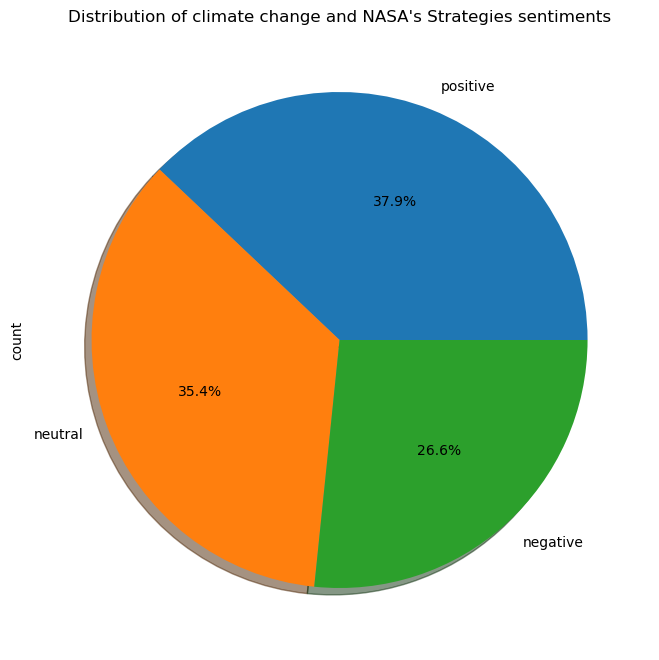

In [21]:
df_grp=df['Climate_Change_NASA_Communication_Strategies_Sentiments'].value_counts()
df_grp.plot(kind='pie',figsize=(8,9),labels=df_grp.index,autopct='%1.1f%%',shadow=True)
plt.title('Distribution of climate change and NASA\'s Strategies sentiments')
plt.show()

In [39]:
df['Date']=df['date'].dt.date

In [74]:
df['Date']

0      2022-09-07
1      2022-09-08
2      2022-09-07
3      2022-09-08
4      2022-09-07
          ...    
517    2022-12-22
518    2022-12-22
519    2022-12-22
520    2022-12-22
521    2022-12-22
Name: Date, Length: 522, dtype: object

In [40]:
df['Date']=pd.to_datetime(df['Date'])

In [79]:
df.head()

,date,likesCount,profileName,commentsCount,text,Climate_Change_NASA_Communication_Strategies_Sentiments,Date
0,2022-09-07 17:12:32+00:00,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,0.0,Neat comparison I have not heard it before.\n ...,positive,2022-09-07
1,2022-09-08 14:51:13+00:00,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,0.0,An excellent way to visualise the invisible T...,positive,2022-09-08
2,2022-09-07 17:19:41+00:00,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2 ghg in the troposphere affect the...,positive,2022-09-07
3,2022-09-08 00:51:30+00:00,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,0.0,excellent post I defo feel the difference o...,positive,2022-09-08
4,2022-09-07 19:06:20+00:00,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,Yes and carbon dioxide does not harm the Eart...,positive,2022-09-07


In [85]:
df_grp

Climate_Change_NASA_Communication_Strategies_Sentiments
positive    199
neutral     185
negative    138
Name: count, dtype: int64

## Trend of shifts in public sentiments over a period

In [25]:
df_trend=df.groupby(['Date','Climate_Change_NASA_Communication_Strategies_Sentiments'])['Climate_Change_NASA_Communication_Strategies_Sentiments'].size()
#df_trend.columns=['Sentiments_Count']
df_trend

Date        Climate_Change_NASA_Communication_Strategies_Sentiments
2020-09-15  negative                                                   12
            neutral                                                    25
            positive                                                   18
2020-09-16  negative                                                   23
            neutral                                                    30
                                                                       ..
2023-12-17  positive                                                    1
2023-12-20  neutral                                                     1
2023-12-22  positive                                                    1
2023-12-24  negative                                                    1
2023-12-25  neutral                                                     1
Name: Climate_Change_NASA_Communication_Strategies_Sentiments, Length: 119, dtype: int64

In [28]:
df_trend=df_trend.to_frame()
df_trend

Climate_Change_NASA_Communication_Strategies_Sentiments
Date       Climate_Change_NASA_Communication_Strategies_Se...                                                         
2020-09-15 negative                                                                                           12      
           neutral                                                                                            25      
           positive                                                                                           18      
2020-09-16 negative                                                                                           23      
           neutral                                                                                            30      
...                                                                                                          ...      
2023-12-17 positive                                                                                            1      
2023-12-20 neutral                                                                                             1      
2023-12-22 positive                                                                                            1      
2023-12-24 negative                                                                                            1      
2023-12-25 neutral                                                                                             1      

[119 rows x 1 columns]

In [29]:
df_trend.rename(columns={'Climate_Change_NASA_Communication_Strategies_Sentiments':'Sentiment_Counts'},inplace=True)
df_trend.reset_index()
df_trend

Sentiment_Counts
Date       Climate_Change_NASA_Communication_Strategies_Se...                  
2020-09-15 negative                                                          12
           neutral                                                           25
           positive                                                          18
2020-09-16 negative                                                          23
           neutral                                                           30
...                                                                         ...
2023-12-17 positive                                                           1
2023-12-20 neutral                                                            1
2023-12-22 positive                                                           1
2023-12-24 negative                                                           1
2023-12-25 neutral                                                            1

[119 rows x 1 columns]

In [33]:
df_trend=df_trend.reset_index()

In [35]:
df_trend

,Date,Climate_Change_NASA_Communication_Strategies_Sentiments,Sentiment_Counts
0,2020-09-15,negative,12
1,2020-09-15,neutral,25
2,2020-09-15,positive,18
3,2020-09-16,negative,23
4,2020-09-16,neutral,30
...,...,...,...
114,2023-12-17,positive,1
115,2023-12-20,neutral,1
116,2023-12-22,positive,1
117,2023-12-24,negative,1


In [39]:
df_trend_pos=df_trend[df_trend['Climate_Change_NASA_Communication_Strategies_Sentiments']=='positive']
df_trend_pos

,Date,Climate_Change_NASA_Communication_Strategies_Sentiments,Sentiment_Counts
2,2020-09-15,positive,18
5,2020-09-16,positive,35
8,2020-09-17,positive,8
13,2021-09-22,positive,5
16,2021-09-23,positive,26
19,2021-09-24,positive,1
24,2021-10-31,positive,3
27,2021-11-01,positive,4
30,2021-11-02,positive,4
32,2021-11-03,positive,1


## Trends of positive sentiments

C:\Users\Krishna Kumar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Krishna Kumar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


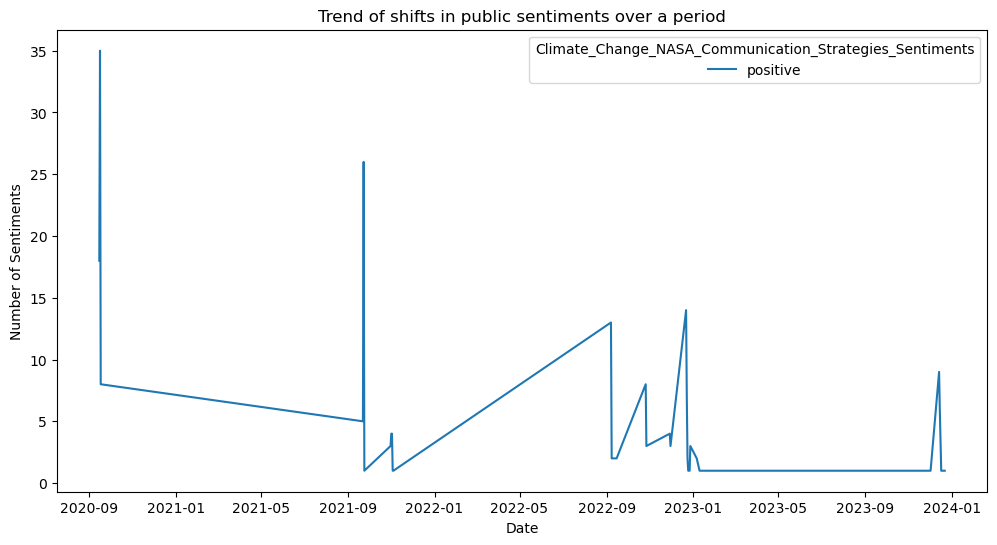

In [40]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date',y='Sentiment_Counts',hue='Climate_Change_NASA_Communication_Strategies_Sentiments',data=df_trend_pos)
plt.title('Trend of shifts in public sentiments over a period')
plt.xlabel('Date')
plt.ylabel('Number of Sentiments')
plt.show()

In [42]:
df_trend_neg=df_trend[df_trend['Climate_Change_NASA_Communication_Strategies_Sentiments']=='negative']
df_trend_neg

,Date,Climate_Change_NASA_Communication_Strategies_Sentiments,Sentiment_Counts
0,2020-09-15,negative,12
3,2020-09-16,negative,23
6,2020-09-17,negative,2
11,2021-09-22,negative,5
14,2021-09-23,negative,16
17,2021-09-24,negative,2
20,2021-09-27,negative,1
21,2021-10-04,negative,1
22,2021-10-31,negative,7
25,2021-11-01,negative,8


## Trend of negative sentiments

C:\Users\Krishna Kumar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Krishna Kumar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


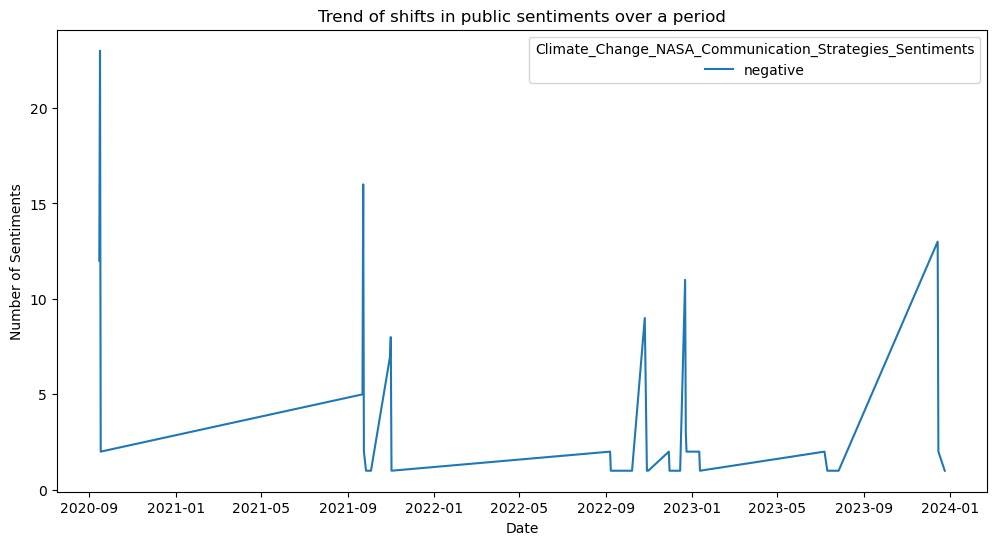

In [43]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date',y='Sentiment_Counts',hue='Climate_Change_NASA_Communication_Strategies_Sentiments',data=df_trend_neg)
plt.title('Trend of shifts in public sentiments over a period')
plt.xlabel('Date')
plt.ylabel('Number of Sentiments')
plt.show()

## Trend of sentiments over a period

C:\Users\Krishna Kumar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Krishna Kumar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


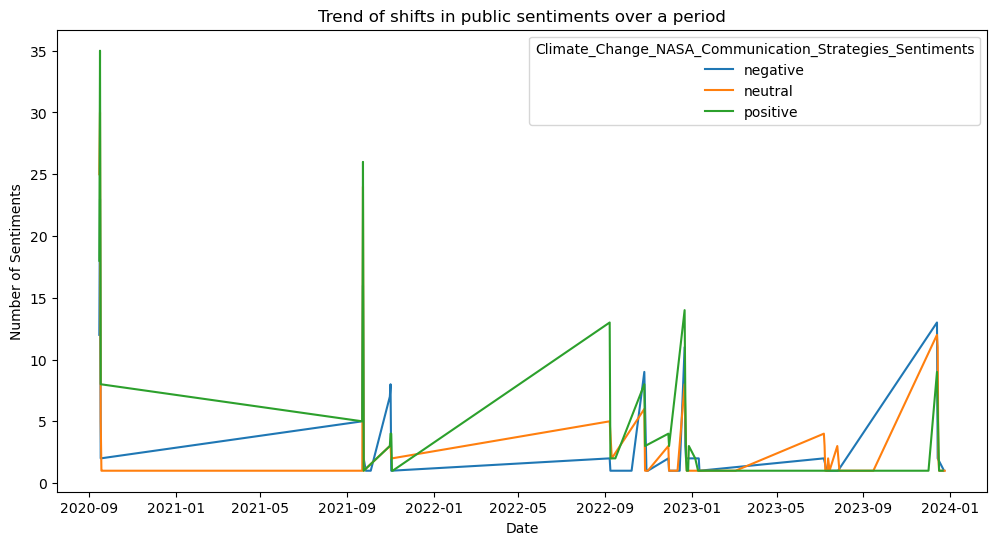

In [38]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date',y='Sentiment_Counts',hue='Climate_Change_NASA_Communication_Strategies_Sentiments',data=df_trend)
plt.title('Trend of shifts in public sentiments over a period')
plt.xlabel('Date')
plt.ylabel('Number of Sentiments')
plt.show()

In [42]:
df.isnull().sum()

date                                                       0
likesCount                                                 0
profileName                                                0
commentsCount                                              0
text                                                       0
Climate_Change_NASA_Communication_Strategies_Sentiments    0
Label_Sentiment                                            0
Date                                                       0
dtype: int64

# Model building and Evaluation

## Sequential Recurrent Neural Networks(RNN) model

In [43]:
tokenizer=Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text'])

In [44]:
encoded_tokens=tokenizer.texts_to_sequences(df['text'])

In [45]:
encoded_tokens

[[1506,
  920,
  13,
  25,
  18,
  921,
  8,
  146,
  13,
  54,
  209,
  9,
  46,
  5,
  91,
  6,
  1507,
  1508,
  50,
  106,
  4,
  1509,
  37,
  1510,
  1511,
  21,
  8,
  664,
  238,
  7,
  24,
  47],
 [69, 332, 147, 2, 1512, 1, 922, 260],
 [114, 1, 46, 923, 7, 1, 924, 293, 1, 925, 127, 128, 1, 924, 261, 22, 926],
 [332,
  210,
  13,
  1513,
  506,
  1,
  294,
  65,
  13,
  29,
  665,
  4,
  1,
  141,
  434,
  142,
  506,
  1514],
 [295,
  4,
  44,
  67,
  114,
  18,
  1515,
  1,
  26,
  91,
  17,
  45,
  12,
  927,
  8,
  129,
  2,
  22,
  371,
  15,
  19,
  1516,
  21,
  666],
 [332, 507, 93, 1517, 2, 1, 1518, 1519, 1520, 928, 929, 7, 1521, 1522],
 [13,
  211,
  50,
  1523,
  3,
  1524,
  930,
  16,
  1525,
  333,
  506,
  93,
  93,
  190,
  23,
  931,
  296],
 [35, 1, 26, 163, 101, 6, 1526, 3, 92, 508, 118],
 [295, 4, 18, 191, 509, 6, 1527, 932, 9, 1528, 1529, 5, 933, 81, 8, 154],
 [934, 46, 86, 54, 155, 8, 69, 372, 210],
 [97, 1, 935, 435, 107, 38, 75, 1, 510, 435],
 [50, 42, 1

In [46]:
ctr=0
for i in range(len(encoded_tokens)):
    ctr=ctr+len(encoded_tokens[i])
print(ctr)

16753


In [47]:
print(len(encoded_tokens[0]))

32


In [48]:
padded_seq=pad_sequences(encoded_tokens,maxlen=50)

In [71]:
padded_seq

array([[   0,    0,    0, ...,    7,   24,   47],
       [   0,    0,    0, ...,    1,  923,  260],
       [   0,    0,    0, ...,  261,   22,  927],
       ...,
       [   0,    0,    0, ...,  795, 3316,   34],
       [   0,    0,    0, ...,    0, 3317, 3318],
       [   0,    0,    0, ...,   12,  154,  366]])

In [135]:
len(padded_seq[5])

50

In [97]:
#vocab_size=
embedding_vector_length=50
modelnlpsa=Sequential()
#modelnlpsa.add(Layer=4)
modelnlpsa.add(Dense(2,activation='sigmoid'))
modelnlpsa.build(input_shape=((None,50)))
modelnlpsa.add(Embedding(5000,50))

modelnlpsa.add(SpatialDropout1D(0.25))
modelnlpsa.add(LSTM(1,dropout=0.5,recurrent_dropout=0.5))
modelnlpsa.add(Dropout(0.2))

modelnlpsa.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(modelnlpsa.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 2)                   │             102 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 2, 50)               │         250,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 2, 50)               │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1)                   │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 250,310 (977.77 KB)

 Trainable params: 250,310 (977.77 KB)

 Non-trainable params: 0 (0.00 B)

None


In [98]:
nlpsa=modelnlpsa.fit(padded_seq,Label_Sentiment[0],epochs=8,batch_size=50)

Epoch 1/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3573 - loss: nan
Epoch 2/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3719 - loss: nan 
Epoch 3/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3889 - loss: nan 
Epoch 4/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3888 - loss: nan 
Epoch 5/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3837 - loss: nan 
Epoch 6/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3972 - loss: nan 
Epoch 7/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3776 - loss: nan
Epoch 8/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3936 - loss: nan 


In [104]:
ypred=[]
arr_label=[]
arr_label_code=[]

ypred=modelnlpsa.predict(padded_seq)
       
    

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## Support Vector machine model

In [55]:
X=df['text']
y=df['Climate_Change_NASA_Communication_Strategies_Sentiments']

In [56]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2,random_state=40)

In [93]:
print(X_train.shape)
print(X_test.shape)

(417,)
(105,)


In [109]:
Y_train.shape

(417,)

In [57]:
tfidfvectorizer=TfidfVectorizer()
tfidf_features_train=tfidfvectorizer.fit_transform(X_train)
tfidf_features_test=tfidfvectorizer.fit_transform(X_test)

In [85]:
tfidf_features_test.shape

(105, 1441)

In [99]:
tfidf_features_train.shape[1]

2796

In [58]:
num_features=tfidf_features_train.shape[1]
num_select=int(num_features*0.5154)
selected_features=np.random.choice(num_features,num_select,replace=False)


In [124]:
len(selected_features)

1441

In [59]:
model_svm=SVC(kernel='rbf',random_state=42)

In [60]:
model_svm.fit(tfidf_features_train[:,selected_features],Y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [61]:
y_pred=model_svm.predict(tfidf_features_test)


In [62]:
Y_test.reset_index()

,index,Climate_Change_NASA_Communication_Strategies_Sentiments
0,51,positive
1,511,positive
2,395,negative
3,408,negative
4,441,positive
...,...,...
100,141,positive
101,341,neutral
102,82,positive
103,18,neutral


In [63]:
Y_test.to_frame()

,Climate_Change_NASA_Communication_Strategies_Sentiments
51,positive
511,positive
395,negative
408,negative
441,positive
...,...
141,positive
341,neutral
82,positive
18,neutral


In [64]:
Y_test1=Y_test.index

In [65]:
ypred_acc=ypred[:105,]

In [82]:
print('Accuracy score of svm model is ',100*(accuracy_score(Y_test,y_pred)))

Accuracy score of svm model is  48.57142857142857


In [86]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        29
     neutral       0.41      0.80      0.54        30
    positive       0.59      0.59      0.59        46

    accuracy                           0.49       105
   macro avg       0.33      0.46      0.38       105
weighted avg       0.37      0.49      0.41       105



For neutral class recall is 80% which means that False Negative is less.  For positive class precision, recall and f1 score all 59%.  Thus, for positive class False positives and False negatives are equal.

## Confusion Matrix

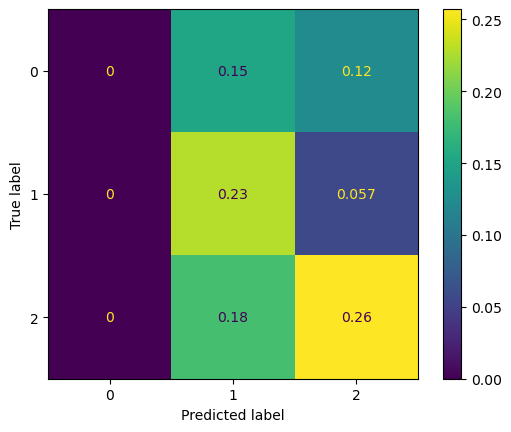

In [90]:
conf_matrix=confusion_matrix(Y_test,y_pred,normalize='all')
cmdsvm=ConfusionMatrixDisplay(conf_matrix)
cmdsvm.plot()

* This is a normalized confusion matrix.
* For class 1(neutral) 23% are correctly classified. Out of 25 samples 24 are correctly classified.
* For class 2(positive) 26% are correctly classified. Out of 46 samples 27 are correctly classified.